In [7]:
from data_processing import SDTDataset, GradientDataset
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
from torchvision.transforms import v2 as transformsv2
from instance_seg import gaussian_noise
from skimage.filters.rank import gradient
from skimage.morphology import disk
import skimage.io as skio

In [18]:
transform = transforms.Compose(
        [
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomVerticalFlip(0.5),  
            transforms.RandomRotation([90,90]),
            transforms.RandomCrop(256)   
            ]
    )
img_transforms = transforms.Compose(
    [
        #transforms.GaussianBlur(kernel_size=5, sigma=5),
        #transformsv2.Lambda(salt_and_pepper_noise),
        transformsv2.Lambda(gaussian_noise)
    ]
)
img_transforms = None

ignore_background = False  # whether to ignore non-segmented cells
center_crop = True  # whether to do a center crop
pad = 256  # min size in either dimension, will pad smaller images up to this size
watershed_scale = 5

print("Loading data ...")
train_data = SDTDataset(transform=transform, img_transform=img_transforms, train=True, return_mask=True, ignore_background=ignore_background, 
                        center_crop=center_crop, pad=pad, watershed_scale=watershed_scale)
train_loader = DataLoader(train_data, batch_size=5, shuffle=False, num_workers=8)
val_data = SDTDataset(transform=None, img_transform=None, train=False, return_mask=True, ignore_background=False, 
                        center_crop=center_crop, pad=pad, mean=train_data.mean, std=train_data.std, watershed_scale=watershed_scale)
val_loader = DataLoader(val_data, batch_size=5)


Loading data ...


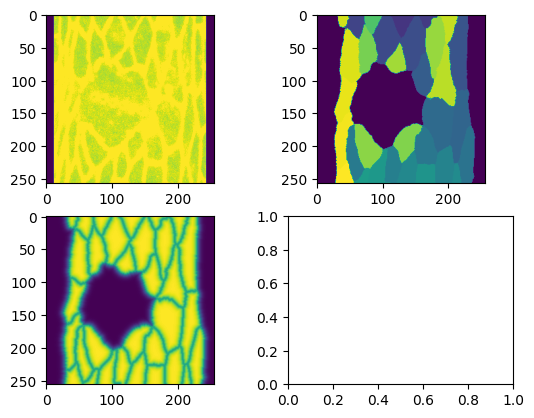

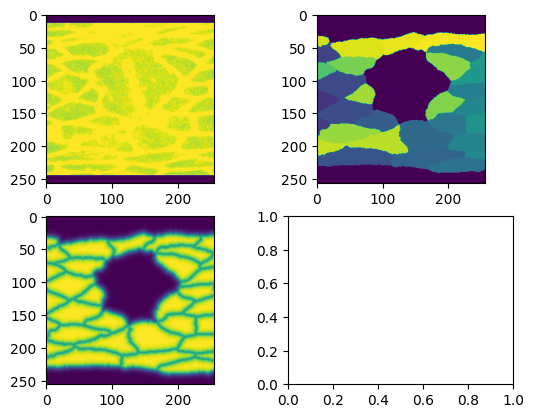

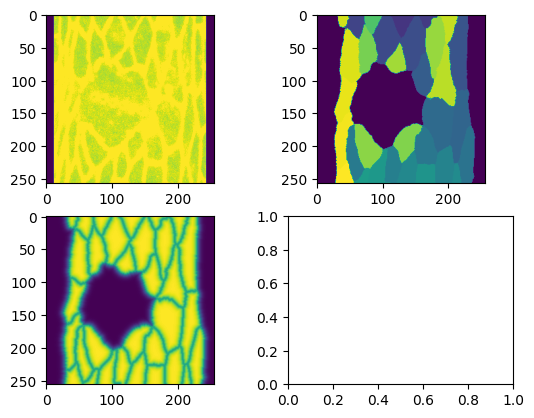

In [19]:
train_images = train_data[60]
train_images = [np.squeeze(this_img) for this_img in train_images]
val_images = val_data[60]
val_images = [np.squeeze(this_img) for this_img in val_images]
skio.imshow_collection(train_images)
skio.imshow_collection(val_images)

In [5]:
print(train_data.ignore_masks)

AttributeError: 'GradientDataset' object has no attribute 'ignore_masks'

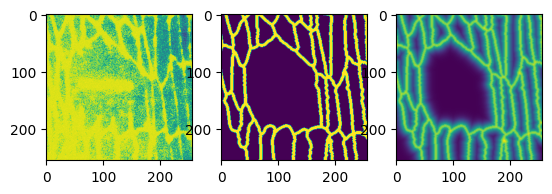

In [6]:
idx = 50
img, mask, sdt = train_data[idx]
#ignore_mask = train_data.get_ignore_mask(idx)
fig, ax = plt.subplots(1,3)
ax[0].imshow(img[0])
ax[1].imshow(mask[0])
ax[2].imshow(sdt[0])
# ax[3].imshow(ignore_mask[0])

plt.show()

In [5]:
# To test if we  can train the model with this data
from model import UNet
from torch.utils.tensorboard import SummaryWriter
import torch
from instance_seg import EarlyStopper, train
from tqdm import tqdm
from torch.utils.data import DataLoader

ignore_background = True
center_crop = False
device='cuda'

unet = UNet(
    depth=4,
    in_channels=1,
    out_channels=1,
    final_activation="Tanh",
    num_fmaps=16,
    fmap_inc_factor=2,
    downsample_factor=2,
    padding="same",
    upsample_mode="nearest",
    )

learning_rate = 1e-4
loss = torch.nn.MSELoss()
writer = SummaryWriter()
optimizer = torch.optim.Adam(unet.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, min_lr=1e-8)

early_stopper = EarlyStopper(patience=10)
for epoch in tqdm(range(1)):
    train(
        unet,
        train_loader,
        optimizer,
        loss,
        epoch,
        log_interval=10,
        device=device,
        tb_logger=writer,
        ignore_background=ignore_background
    )

  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[[[91.6948, 91.5450, 91.3221,  ..., 33.9791, 33.9860, 33.9906],
          [91.6709, 91.5201, 91.3025,  ..., 33.9781, 33.9853, 33.9901],
          [91.6309, 91.4578, 91.2055,  ..., 33.9774, 33.9849, 33.9898],
          ...,
          [67.8505, 67.7772, 67.6682,  ..., 12.1686, 16.2325, 19.6497],
          [67.8556, 67.7853, 67.6811,  ..., 11.0185, 15.5744, 19.2571],
          [67.8638, 67.7982, 67.7013,  ..., 11.0185, 15.5744, 19.2571]]],


        [[[50.5115, 50.2810, 49.9447,  ..., -0.0000, -0.0000, -0.0000],
          [50.4404, 50.1944, 49.8480,  ..., -0.0000, -0.0000, -0.0000],
          [50.3566, 50.0640, 49.6454,  ..., -0.0000, -0.0000, -0.0000],
          ...,
          [15.2962, 14.9840, 14.5479,  ..., -0.0000, -0.0000, -0.0000],
          [15.3893, 15.1302, 14.7763,  ..., -0.0000, -0.0000, -0.0000],
          [15.4876, 15.2815, 14.9840,  ..., -0.0000, -0.0000, -0.0000]]],


        [[[-0.0000, -0.0000, -0.0000,  ..., 35.5354, 36.9409, 37.9176],
          [-0.0000, -0.000

100%|██████████| 1/1 [00:16<00:00, 16.95s/it]
